In [181]:
import io
import os
from google.protobuf.json_format import MessageToJson
import json
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
#Google.cloudをimport
from google.cloud import vision
from google.cloud import translate_v2 as translate
from google.cloud.vision import types
import numpy as np
import glob
# テキスト解析
import MeCab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [182]:
#画像からラベルを検出する関数
def get_label(base_dir, pic):
    #対象となる画像の絶対パス
    file_name = base_dir + pic

    #画像を読み込み
    with io.open(file_name, 'rb') as image_file:
        content = image_file.read()
        image = types.Image(content=content)
    
    #画像を表示
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
        
    #visionクライアントの初期化
    client = vision.ImageAnnotatorClient()

    #ラベル検出
    response = client.label_detection(image=image)
    labels = response.label_annotations

    #検出したラベルを格納するリスト
    en_label = []

    #リストに結果を格納
    for label in labels:
        en_label.append(label.description)
    
    #結果を表示
    print("検出した要素(in English)は以下")
    print(en_label)
    print( "\n")

    return en_label

In [183]:
#翻訳関数
def translate_lan(text, tag_language):
    #翻訳先が英語ならそのまま返す
    if tag_language == 'en':
        return text
    translate_client = translate.Client()
    result = translate_client.translate(text, target_language=tag_language)
    return result['translatedText']

In [184]:
#ラベルを取り扱いやすくする関数
def label_transaction(en_label, tag_language):
    ja_label = []
    for text in en_label:
        transtext = translate_lan(text, tag_language)
        ja_label.append(transtext)
    print("ラベルの日本語標記は以下")
    print(ja_label)
    print("\n")

    #よく検出される食材名以外のものを削除する
    exception = ['皿', '調理済み', '食物', '成分', 'ボトル']
    for text in exception:
        #NaNのときのエラー回避
        try:
            ja_label.remove(text)
        except ValueError:
            pass

    ja_label_unique = list(set(ja_label))  #重複を削除
    print("処理後は以下")
    print(ja_label_unique) 
    print("\n")
    
    return ja_label_unique

検出した要素(in English)は以下
['Egg', 'Egg yolk', 'Egg white', 'Food', 'Egg', 'Dish', 'Ingredient', 'Cuisine', 'Poached egg', 'Fried egg']


ラベルの日本語標記は以下
['卵', '卵黄', '卵白', '食物', '卵', '皿', '成分', '調理済み', 'ポーチドエッグ', '目玉焼き']


処理後は以下
['卵黄', '卵白', '卵', '目玉焼き', 'ポーチドエッグ']




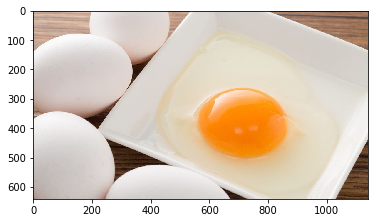

In [185]:
base_dir = r"/Users/tahara_so70/Desktop/Sample" #今回の作業用ディレクトリ
pic=r"/tamago.jpg" #対象となる画像
tag_language = 'ja' #翻訳先言語。今回は英語から日本語に。

#認証用に発行されたJSONキーの絶対パス
credential_path = base_dir + r'/amplified-cache-277509-4b71fdd784b2.json'
    
#サービスアカウントキーへのパスを通す
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path
    
en_label = get_label(base_dir, pic) #画像から要素検出 in English
    
ja_label_unique = label_transaction(en_label, tag_language) #日本語に変換し、食材以外と重複を取り除く

つくレポは年をまたぐので、処理する際には全てを結合する必要がある。
for文で各年のつくレポを読み込んで各々保存しようとしたが、動的な変数名を各つくレポにつけることができなかった (例:report2012=pd.read~)
その為、一旦空のIDとreportという2つのカラムを持った空のデータフレームを用意し、そこに逐次ツクレポを合体させることにする。

In [186]:
report_df = pd.DataFrame(columns=['ID','report'] ) #全てのつくレポを格納するdf

year = []
for i in range(1998,2001):
    year.append(i)

for i in year:
    report = pd.read_csv(f"/Users/tahara_so70/Desktop/Sample/MDA/report/report{i}.csv", names=["ID", "report"], usecols=[0,2])
    report_df = pd.concat([report_df, report]) #report_dfに各年のツクレポを縦に合体させる

MeCabを利用してツクレポから形容詞を抜き出して分割する

In [187]:
def split_text(text, target_pos=["形容詞"]):
    tagger = MeCab.Tagger()
    text_str = text
    tagger.parse('')
    node = tagger.parseToNode(text_str)

    words = []
    while node:
        l = node.feature.split(",")
        pos = l[0]
        if pos in target_pos:
            # unicode 型に戻す
            if l[6] == "*":
                word = node.surface # 変化しない語は表層形をそのまま使う
            else:
                word = l[6]         # 動詞や形容詞は原形を使う
            words.append(word)
        node = node.next
    return " ".join(words)          # スペース区切りで単語を結合し返す

In [188]:
report_df["split"] = report_df["report"].map(split_text)
report_df.head()

,ID,report,split
0,12d462eae4db630ea5280380ebc99da3318080ae,"""上新粉＆白玉粉を混ぜて作りました。もちもちで春の香りたっぷり！""",
1,12d462eae4db630ea5280380ebc99da3318080ae,"""楽してよもぎ粉使いました。皮が固いですが美味しくできました～♪""",楽しい 固い 美味しい
2,12d462eae4db630ea5280380ebc99da3318080ae,"""熱湯を少なめで、フリーズドライの蓬はを使い、美味しく出来ました。""",美味しい
3,12d462eae4db630ea5280380ebc99da3318080ae,"""所々あんこはみでちゃった(>_<)明日の朝食べるねん〜♪""",
4,12d462eae4db630ea5280380ebc99da3318080ae,"""よもぎの香りがしておいしくできました。ありがとうございました。""",おいしい


In [189]:
tsuku_report_df = report_df\
    .groupby("ID")["split"]\
    .apply(lambda x: "%s" % ' '.join(x))\
    .reset_index()
tsuku_report_df.head()

,ID,split
0,019e8d496aadb8270f64ce0b6444f7951261d81a,おいしい 甘い 美味しい 美味しい イイ 良い 良い 美味しい 美味しい 香ばしい...
1,01cf8a07dd2186d9d9817ed4a255e9fde9e7e05f,
2,01f7c95b71a48a39cb534e7b31d743f7bebd7116,美味しい
3,033a1db21875f8125016ca535d057d715ef88dee,美味しい
4,033c085f68fb442600b1d42b16744aad4dbb207f,おいしい


In [190]:
vectorizer = TfidfVectorizer()
tfidfs = vectorizer.fit_transform(tsuku_report_df["split"])
tfidfs

<393x143 sparse matrix of type '<class 'numpy.float64'>'
	with 918 stored elements in Compressed Sparse Row format>

In [191]:
#TFIDF の結果からi 番目のドキュメントの特徴的な上位 n 語を取り出す(今回はn=1しか使わないが...)
def extract_feature_words(terms, tfidfs, i, n):
    tfidf_array = tfidfs[i]
    top_n_idx = tfidf_array.argsort()[-n:][::-1]
    words = [terms[idx] for idx in top_n_idx]
    return words

In [192]:
# index 順の単語のリスト
terms = vectorizer.get_feature_names()

In [193]:
top_n = 1  # 上位1つ
highscore_words = [
    extract_feature_words(terms, tfidfs.toarray(), i, top_n)
    for i
    in range(len(tsuku_report_df.index))
]
highscore_words_str = [" ".join(l) for l in highscore_words]
tsuku_report_df["highscore_words"] = highscore_words_str
tsuku_report_df.head()

,ID,split,highscore_words
0,019e8d496aadb8270f64ce0b6444f7951261d81a,おいしい 甘い 美味しい 美味しい イイ 良い 良い 美味しい 美味しい 香ばしい...,甘い
1,01cf8a07dd2186d9d9817ed4a255e9fde9e7e05f,,高い
2,01f7c95b71a48a39cb534e7b31d743f7bebd7116,美味しい,美味しい
3,033a1db21875f8125016ca535d057d715ef88dee,美味しい,美味しい
4,033c085f68fb442600b1d42b16744aad4dbb207f,おいしい,おいしい


In [194]:
## TFIDF の結果からi 番目のドキュメントの最も高いスコアをとりだす
def extract_score(tfidfs, i):
    tfidf_array = tfidfs[i]
    score = tfidf_array.max()
    return score

In [219]:
high_score = [
    extract_score(tfidfs.toarray(), i)
    for i
    in range(len(tsuku_report_df.index))
]
tsuku_report_df["TFIDF"] = high_score
tsuku_report_df.head()

,ID,split,highscore_words,TFIDF
0,019e8d496aadb8270f64ce0b6444f7951261d81a,おいしい 甘い 美味しい 美味しい イイ 良い 良い 美味しい 美味しい 香ばしい...,甘い,0.64489
1,01cf8a07dd2186d9d9817ed4a255e9fde9e7e05f,,高い,0.00000
2,01f7c95b71a48a39cb534e7b31d743f7bebd7116,美味しい,美味しい,1.00000
3,033a1db21875f8125016ca535d057d715ef88dee,美味しい,美味しい,1.00000
4,033c085f68fb442600b1d42b16744aad4dbb207f,おいしい,おいしい,1.00000


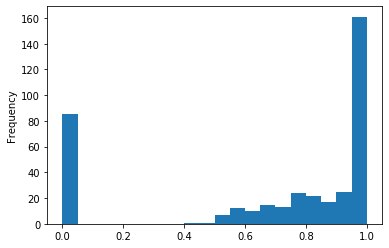

In [221]:
tsuku_report_df['TFIDF'].plot.hist(bins=20)

In [222]:
tsuku_report_df.loc[tsuku_report_df['TFIDF'] ==1, 'TFIDF'] = 0.7 #splitでワードが1つしかない場合、偏りが大きいのでTFIDFが1になるので0.5に変換
tsuku_report_df.head(5)
#tsuku_report_df = tsuku_report_df.drop('A', axis=1)

,ID,split,highscore_words,TFIDF
0,019e8d496aadb8270f64ce0b6444f7951261d81a,おいしい 甘い 美味しい 美味しい イイ 良い 良い 美味しい 美味しい 香ばしい...,甘い,0.64489
1,01cf8a07dd2186d9d9817ed4a255e9fde9e7e05f,,高い,0.00000
2,01f7c95b71a48a39cb534e7b31d743f7bebd7116,美味しい,美味しい,0.70000
3,033a1db21875f8125016ca535d057d715ef88dee,美味しい,美味しい,0.70000
4,033c085f68fb442600b1d42b16744aad4dbb207f,おいしい,おいしい,0.70000


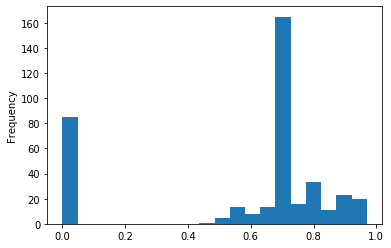

In [225]:
tsuku_report_df['TFIDF'].plot.hist(bins=20)

In [223]:
#任意のワードを材料に含むおすすめレシピの提示

selected_word = "卵"

master_df = pd.DataFrame(columns=['ID','title','ingredient'] ) #全てのつくレポを格納するdf

year = []
for i in range(1998,2001):
    year.append(i)

for i in year:
    ingredient = pd.read_csv(f"/Users/tahara_so70/Desktop/Sample/MDA/ingredient/ingredient{i}.csv", names=["ID", "ingredient"], usecols=[0,1])
    #ingredientから指定した素材の行だけ抽出する
    ingredient_in = ingredient[ingredient["ingredient"].isin([selected_word])]
    recipe = pd.read_csv(f"/Users/tahara_so70/Desktop/Sample/MDA/recipe/recipe{i}.csv",names=["ID","title"],usecols=[0,2])
    df = pd.merge(ingredient_in, recipe, on = "ID", how = "left") #ingreとrecipeをマージ
    df = df.loc[:,['ID','title','ingredient']]
    master_df = pd.concat([master_df, df]) #masterに直列でつなぐ
master_df = pd.merge(master_df, tsuku_report_df, on = "ID", how = "left") 
master_df = master_df[master_df["highscore_words"].isin(["おいしい", "美味しい"])]
master_df = master_df.sort_values("TFIDF", ascending=False) #TFIDFスコア順にする
master_df.head()

,ID,title,ingredient,split,highscore_words,TFIDF
660,b9eff8e2a743f8ae84967c4f4594e91a8832a6d6,りんごサワーケーキ,卵,おいしい おいしい 美味しい,おいしい,0.944935
72,03ddfb68bdc001788da3a7a68306c7047a8b1152,煮込みハンバーグ･しろ風,卵,美味しい おいしい おいしい 美味しい,おいしい,0.822058
144,1dabccbd3c5d7bfaec6dd30873d752d4c16a4774,日向のとん平焼き,卵,おいしい 美味しい,おいしい,0.822058
354,6092a7203fe8c320990580e303b0fc21ae93073d,玉米湯,卵,嬉しい 美味しい 美味しい 美味しい,美味しい,0.780888
746,d560ab553a60f2a77ac001676fcad37fc8706140,キムチ雑炊,卵,美味しい まるい 寒い 美味しい 寒い おいしい 美味しい 美味しい やすい こい 美味...,美味しい,0.773155


In [224]:
#画像内の要素を材料に含むおすすめレシピ

for text in ja_label_unique:
        print("・" + text + "を使う料理")
        master_df = pd.DataFrame(columns=['ID','title','ingredient'] ) #全てのつくレポを格納するdf
        for i in year:
            ingredient = pd.read_csv(f"/Users/tahara_so70/Desktop/Sample/MDA/ingredient/ingredient{i}.csv", names=["ID", "ingredient"], usecols=[0,1])
            #ingredientから指定した素材の行だけ抽出する
            ingredient_in = ingredient[ingredient["ingredient"].isin([text])]
            ingredient_in.head()
            recipe = pd.read_csv(f"/Users/tahara_so70/Desktop/Sample/MDA/recipe/recipe{i}.csv",names=["ID","title"],usecols=[0,2])
            df = pd.merge(ingredient_in, recipe, on = "ID", how = "left") #ingreとrecipeをマージ
            df = df.loc[:,['ID','title','ingredient']]
            master_df = pd.concat([master_df, df]) #masterに直列でつなぐ
        master_df = pd.merge(master_df, tsuku_report_df, on = "ID", how = "left") 
        master_df = master_df[master_df["highscore_words"].isin(["おいしい", "美味しい"])]
        master_df = master_df.sort_values("TFIDF", ascending=False) #TFIDFスコア順にする
        display = master_df.loc[:,['title','TFIDF']]
        print(display.head(5))
        print("\n")

・卵黄を使う料理
                       title     TFIDF
69   ♪簡単・ヘルシー!スイートミルクチョコケーキ♪  0.822058
42                  パンプキンタルト  0.700000
64                 カスタードクリーム  0.700000
72       ダイエットにもお勧め◆もずくそうめん◆  0.700000
115                 基本のタルト生地  0.700000


・卵白を使う料理
                      title     TFIDF
35  ♪簡単・ヘルシー!スイートミルクチョコケーキ♪  0.822058
46                  あずきのムース  0.700000
70            ブロッコリーのかにあんかけ  0.700000


・卵を使う料理
            title     TFIDF
660     りんごサワーケーキ  0.944935
72   煮込みハンバーグ･しろ風  0.822058
144      日向のとん平焼き  0.822058
354           玉米湯  0.780888
746         キムチ雑炊  0.773155


・目玉焼きを使う料理
Empty DataFrame
Columns: [title, TFIDF]
Index: []


・ポーチドエッグを使う料理
Empty DataFrame
Columns: [title, TFIDF]
Index: []


